In [1]:
import sqlite3
import pandas as pd

import config

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
conn = sqlite3.connect(config.mlb_db_path)

In [3]:
roster = pd.read_sql(sql='select * from starters', con=conn)
subs = pd.read_sql(sql='select * from substitutions', con=conn)
plays = pd.read_sql(sql='select * from plays', con=conn)
data = pd.read_sql(sql='select * from game_data', con=conn)

# Game by Game

In [8]:
game_id = plays.loc[6258037]['game_id']

In [59]:
def pitcher_vs_batter(game_id):
    plays_ = plays[plays['game_id'] == game_id]
    
    # for half 0 == away and 1 == home
    p0 = plays[(plays['game_id'] == game_id)
              &(plays['half'] == 0)]
    p1 = plays[(plays['game_id'] == game_id)
              &(plays['half'] == 1)]
    
    # Select starting pitchers
    sp0 = roster[(roster['game_id'] == game_id)
                &(roster['position'] == 1)
                &(roster['team_HA'] == 0)]
    sp1 = roster[(roster['game_id'] == game_id)
                &(roster['position'] == 1)
                &(roster['team_HA'] == 1)]
    
    # Select pitching subs
    ps_0 = subs[(subs['game_id'] == game_id)
                 & (subs['position'] == 1)
                 & (subs['team_HA'] == 1)]
    ps_1 = subs[(subs['game_id'] == game_id) 
                 & (subs['position'] == 1)
                 & (subs['team_HA'] == 0)]
    for df in [ps_0,ps_1]:
        df.rename(columns={'player_id':'pitcher_id',
                         'team_HA':'pitcher_team'},
                         inplace=True)
    ## Apply pitchers to play dataframe
    # Set starting pitchers
    p0.loc[p0.index[0],'pitcher_id'] = sp0['player_id'].tolist()[0]
    p1.loc[p1.index[0],'pitcher_id'] = sp1['player_id'].tolist()[0]
    # Append pitching subs
    p0_ = p0.append(ps_0[['pitcher_id','eventcount']]).sort_values('eventcount')
    p1_ = p1.append(ps_1[['pitcher_id','eventcount']]).sort_values('eventcount')
    # Fill and finalize play pitch dataframe
    p0_['pitcher_id'] = p0_['pitcher_id'].fillna(method='ffill')
    p1_['pitcher_id'] = p1_['pitcher_id'].fillna(method='ffill')
    game_final = p0_.append(p1_).dropna(subset=['game_id']).sort_values('eventcount')
    
    return game_final

In [ ]:
pp = pitcher_vs_batter(game_id=game_id)

In [71]:
%timeit -r 5 pitcher_vs_batter(game_id=game_id)

3.87 s ± 847 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [72]:
# HOURS to run all games
3.87 * len(set(plays['game_id']))/ 60/60

118.06940000000002

# Full DB

In [115]:
def add_pitch_to_plays():
    roster_ = roster[roster['position'] == 1]
    roster_['eventcount'] = -1
    subs_ = subs[subs['position'] == 1]

    pitchers = roster_.append(subs_)
    pitchers['team_HA'] = abs(pitchers['team_HA'] - 1)
    pitchers_ = pitchers[['eventcount','game_id',
                          'player_id','team_HA']].rename(columns={'player_id':'pitcher_id',
                                                                  'team_HA':'half'})

    full = plays.append(pitchers_)
    full_ = full.sort_values(['game_id','half','eventcount'])
    full_ = full_[~full_['game_id'].str.contains('"')]
    full_['pitcher_id'] = full_['pitcher_id'].fillna(method='ffill')
    final = full_.dropna(subset=['inning'])
    return final

In [ ]:
final = add_pitch_to_plays()

In [156]:
final.head()

,count,event,eventcount,game_id,half,inning,pitcher_id,pitches,player_id,event_s
1502436,11,9/F89M,0,ANA199704020,0,1.0,langm001,FBX,garcn001,9
1502437,00,D9/L9LM/R46,1,ANA199704020,0,1.0,langm001,X,valej002,D9
1502438,31,W,2,ANA199704020,0,1.0,langm001,CBBBB,vaugm001,W
1502439,11,8/F8RXD/R6.2-3,3,ANA199704020,0,1.0,langm001,SBX,stanm002,8
1502440,10,64(1)/FO/G6,4,ANA199704020,0,1.0,langm001,B1X,naeht001,64(1)


In [169]:
final['batting_avg'] = final['slugging'] = final['event_s']

In [117]:
%timeit -r 5 add_pitch_to_plays()

39.6 s ± 4.54 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [163]:
def batting_avg(event_series):
    results = 0
    count = 0
    for play_str in event_series:
        cou, res = batting_avg_counter(play_str)
        results += res
        count += cou
    if count == 0:
        return 0
    else:
        return float(results)/float(count)

def batting_avg_counter(play_str):
    for hit in ['S','D','T','HR']:
        if hit in play_str:
            return 1,1
    if "K" in play_str:
        return 1,0
    elif "W" in play_str:
        return 0,0
    else:
        return 1,0

In [175]:
def slugging(event_series):
    results = 0
    count = 0
    for play_str in event_series:
        cou, res = slugging_counter(play_str)
        results += res
        count += cou
    if count == 0:
        return 0
    else:
        return float(results)/float(count)

def slugging_counter(play_str):
    if 'S' in play_str:
        return 1,1
    elif 'D' in play_str:
        return 1,2
    elif 'T' in play_str:
        return 1,3
    elif 'HR' in play_str:
        return 1,4
    elif 'W' in play_str:
        return 0,0
    else: 
        return 1,0

In [176]:
ba = final.groupby(['player_id','pitcher_id']).agg({'batting_avg':batting_avg,
                                                    'slugging':slugging,
                                                    'pitches':'count'})

In [184]:
import matplotlib.pyplot as plt

In [185]:
%matplotlib inline

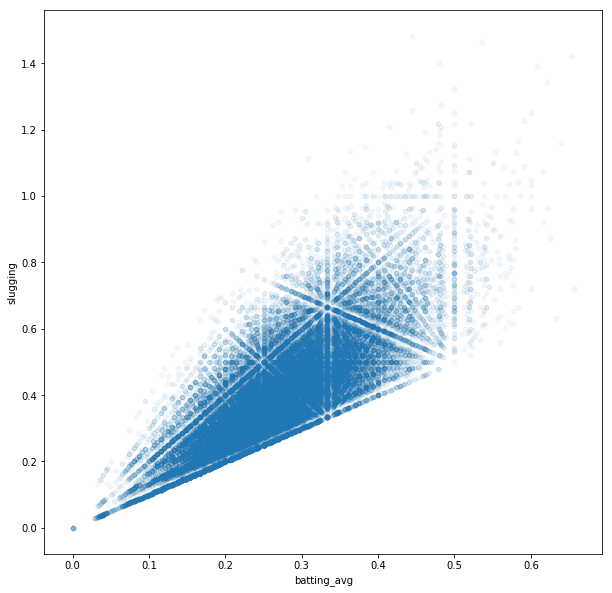

In [196]:
ba[ba['pitches'] > 25].plot(kind='scatter',
                            x='batting_avg',
                            y='slugging',
                            figsize=(10,10),
                            alpha=.05)

In [198]:
f_ = final.groupby(['player_id']).agg({'batting_avg':batting_avg,
                                   'slugging':slugging,
                                   'pitches':'count'})

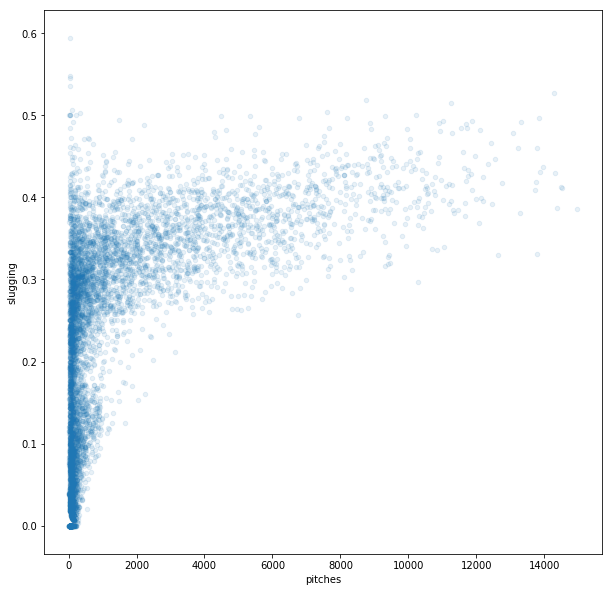

In [214]:
f_[f_['pitches'] > 25].plot(kind='scatter',
                            x='pitches',
                            y='slugging',
                            figsize=(10,10),
                            alpha=.1)

In [200]:
len(f_)

8825